In [ ]:
import pandas as pd
import re

In [ ]:
url = 'https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentiment_opini_film.csv'
df = pd.read_csv(url)
df.head()

,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


In [ ]:
df.drop('Id',axis=1,inplace=True)

In [ ]:
#ubah nama kolom
df = df.rename(columns={'Sentiment':'sentiment',
                        'Text Tweet':'text_tweet'})

#ubah data kategorik menjadi data numerik
df['sentiment'].replace(['negative','positive'], [0,1], inplace=True)

df

,sentiment,text_tweet
0,0,Jelek filmnya... apalagi si ernest gak mutu bg...
1,0,Film king Arthur ini film paling jelek dari se...
2,0,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,0,Ane ga suka fast and furious..menurutku kok je...
4,0,"@baekhyun36 kan gua ga tau film nya, lu bilang..."
...,...,...
195,1,Fargo juga adaptasi dari film yang cukup berha...
196,1,637.000 waw ini sangat keren flm horor dng jum...
197,1,@filmziarah film yang tenang dan menghanyutkan...
198,1,Film yg amat menarik. Kisah cinta & kesetiaan ...


In [ ]:
def pre_processing(text_tweet):
  text_tweet = text_tweet.lower()
  text_tweet = text_tweet.strip()
  text_tweet = re.sub(r'https?://\S+|www\.\S+','', text_tweet)
  text_tweet = re.sub(r'[-+]?[0-9]+','', text_tweet)
  text_tweet = re.sub(r'[^\w\s]','', text_tweet)
  return text_tweet
df['text_tweet'] = df['text_tweet'].apply(pre_processing)

df


,sentiment,text_tweet
0,0,jelek filmnya apalagi si ernest gak mutu bgt a...
1,0,film king arthur ini film paling jelek dari se...
2,0,beexkuanlin sepanjang film gwa berkata kasar t...
3,0,ane ga suka fast and furiousmenurutku kok jele...
4,0,baekhyun kan gua ga tau film nya lu bilang per...
...,...,...
195,1,fargo juga adaptasi dari film yang cukup berha...
196,1,waw ini sangat keren flm horor dng jumlah pen...
197,1,filmziarah film yang tenang dan menghanyutkan ...
198,1,film yg amat menarik kisah cinta kesetiaan yg...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   200 non-null    int64 
 1   text_tweet  200 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [ ]:
!pip install transformers

In [ ]:
sentences = df.text_tweet.values
labels = df.sentiment.values

In [ ]:


from transformers import BertTokenizer

print("Loading BERT Tokenizer")
bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

Loading BERT Tokenizer


In [ ]:
print("Original: ", sentences[0])

print("Tokenized: ", bert_tokenizer.tokenize(sentences[0]))

print("Token IDS: ", bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sentences[0])))

Original:  jelek filmnya apalagi si ernest gak mutu bgt actingnya film sampah
Tokenized:  ['jelek', 'filmnya', 'apalagi', 'si', 'ern', '##est', 'gak', 'mutu', 'bgt', 'act', '##ingnya', 'film', 'sampah']
Token IDS:  [8302, 17943, 2087, 356, 21471, 623, 1489, 4516, 6948, 25100, 8152, 1460, 3876]


In [ ]:
input_ids = []
for sent in sentences:
  encoded_sent = bert_tokenizer.encode(
      sent,
      add_special_tokens= True
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

Original:  jelek filmnya apalagi si ernest gak mutu bgt actingnya film sampah
Token IDs:  [2, 8302, 17943, 2087, 356, 21471, 623, 1489, 4516, 6948, 25100, 8152, 1460, 3876, 3]


In [ ]:
print("Max sentences length: ", max([len(sen) for sen in input_ids]))

Max sentences length:  41


In [ ]:
!pip install keras-preprocessing

In [ ]:
from keras_preprocessing.sequence import pad_sequences

MAX_LEN = 50

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(bert_tokenizer.pad_token, bert_tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 50 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
input_ids[0]

array([    2,  8302, 17943,  2087,   356, 21471,   623,  1489,  4516,
        6948, 25100,  8152,  1460,  3876,     3,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0)for token_id in sent]

  attention_mask.append(att_mask)

# Persiapan Data


In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=2021,
                                                                      test_size=0.2)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=2021,
                                               test_size=0.2)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=2022,
                                                                                  test_size=0.5)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=2022,
                                                     test_size=0.5)

In [ ]:
import numpy as np
print("==Train==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("==Validation==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("==Test==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

==Train==
Input:  (80, 50)
Label:  (80,)
Mask:  (80, 50)
==Validation==
Input:  (80, 50)
Label:  (80,)
Mask:  (80, 50)
==Test==
Input:  (40, 50)
Label:  (40,)
Mask:  (40, 50)


In [ ]:
import torch

train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Pemodelan pre-trained BERT

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p2',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps
                                            )

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

# Training BERT

In [ ]:
device = torch.device("cpu")

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range (0, epochs):

  #===============================
  #          Training
  #===============================

  print("======== Epoch {:} / {:} ========".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.      Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Avarage training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  #===============================
  #          Validation
  #===============================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")



In [ ]:
 import matplotlib.pyplot as plt

 import seaborn as sns

 sns.set(style='darkgrid')
 plt.rcParams["figure.figsize"] = (12,6)

 plt.plot(loss_values, 'b-o')

 plt.title("Training loss")
 plt.xlabel("Epoch")
 plt.ylabel("Loss")

 plt.show()

In [ ]:
import random

# Set seed untuk reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# List untuk menyimpan data pelatihan dan validasi
loss_values = []
train_accuracy_values = []
validation_accuracy_values = []
training_times = []

# Loop pelatihan
for epoch_i in range(0, epochs):

    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, epochs))
    print("Training...")

    t0 = time.time()

    total_loss = 0

    model.train()

    # Inisialisasi akurasi training untuk setiap epoch
    total_train_accuracy = 0
    total_train_steps = 0

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print("Batch {:>5,} of {:>5,}. Elapsed: {:}".format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        # Hitung akurasi training untuk batch saat ini
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        batch_train_accuracy = flat_accuracy(logits, label_ids)

        total_train_accuracy += batch_train_accuracy
        total_train_steps += 1

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    # Hitung rata-rata akurasi training untuk setiap epoch
    epoch_train_accuracy = total_train_accuracy / total_train_steps
    train_accuracy_values.append(epoch_train_accuracy)

    print("   Average training loss: {0:.2f}".format(avg_train_loss))
    print("   Training epoch took: {:}".format(format_time(time.time() - t0)))
    print("   Average training accuracy: {0:.2f}".format(epoch_train_accuracy))

    # Validasi
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("   Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps))
    print("   Validation took: {:}".format(format_time(time.time() - t0)))

    # Simpan data akurasi dan waktu validasi
    validation_accuracy_values.append(eval_accuracy / nb_eval_steps)
    training_times.append(time.time() - t0)

print("Training complete!")


======== Epoch 1 / 5 ========
Training...
   Average training loss: 0.65
   Training epoch took: 0:00:28
   Average training accuracy: 0.57
Running Validation...
   Accuracy: 0.50
   Validation took: 0:00:06
======== Epoch 2 / 5 ========
Training...
   Average training loss: 0.53
   Training epoch took: 0:00:26
   Average training accuracy: 0.81
Running Validation...
   Accuracy: 0.64
   Validation took: 0:00:07
======== Epoch 3 / 5 ========
Training...
   Average training loss: 0.41
   Training epoch took: 0:00:25
   Average training accuracy: 0.92
Running Validation...
   Accuracy: 0.70
   Validation took: 0:00:08
======== Epoch 4 / 5 ========
Training...
   Average training loss: 0.30
   Training epoch took: 0:00:25
   Average training accuracy: 0.96
Running Validation...
   Accuracy: 0.70
   Validation took: 0:00:08
======== Epoch 5 / 5 ========
Training...
   Average training loss: 0.24
   Training epoch took: 0:00:24
   Average training accuracy: 0.98
Running Validation...
   Acc

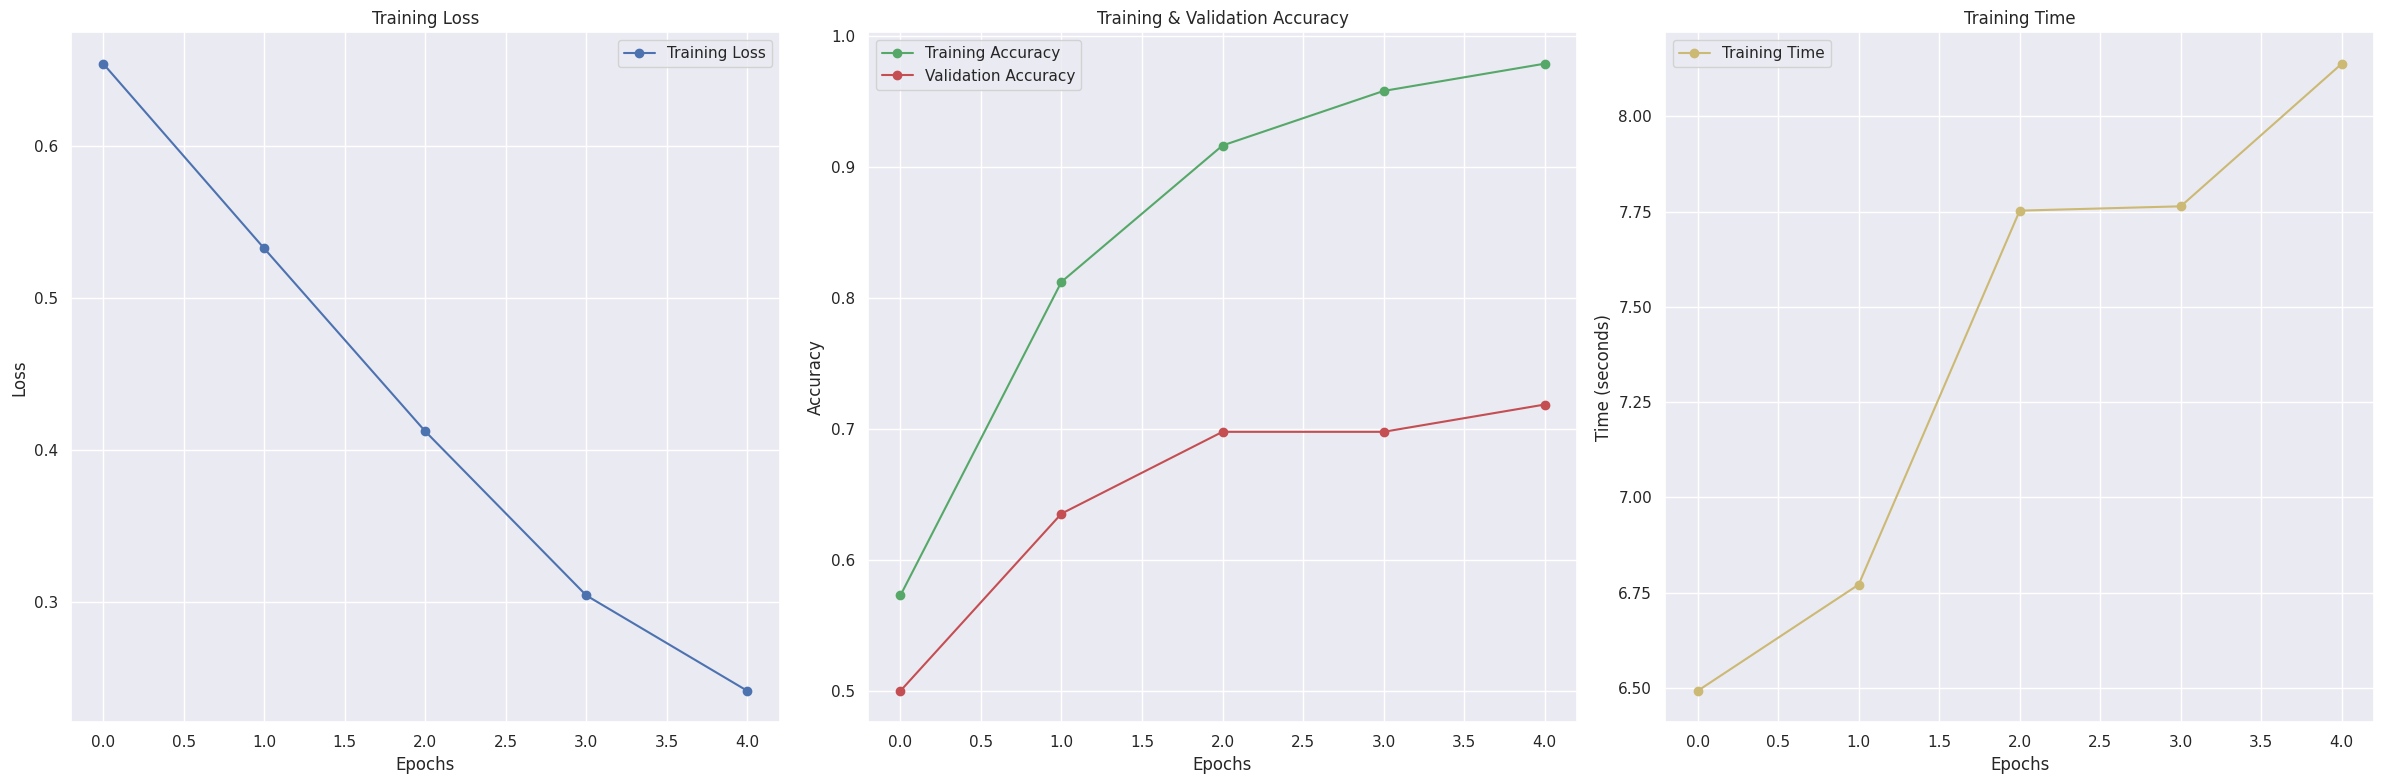

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi Loss Training
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.plot(loss_values, 'b-o', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Visualisasi Akurasi Training
plt.subplot(1, 3, 2)
plt.plot(train_accuracy_values, 'g-o', label='Training Accuracy')
plt.plot(validation_accuracy_values, 'r-o', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Visualisasi Training Time
plt.subplot(1, 3, 3)
plt.plot(training_times, 'y-o', label='Training Time')
plt.title('Training Time')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.legend()

# Tampilkan grafik
plt.tight_layout()
plt.show()


In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch  = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 40 test sentences
 DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient


for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(prediction[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

In [ ]:
flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.814


In [ ]:
# scores for individual batches
matthews_set

[0.827170191868511, 0.7453559924999299]

In [ ]:
from sklearn.metrics import accuracy_score

# Combine the predictions and true labels
predictions = np.concatenate(prediction, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Apply argmax to get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 90.00%


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report with 4 decimal places
report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8400    1.0000    0.9130        21
           1     1.0000    0.7895    0.8824        19

    accuracy                         0.9000        40
   macro avg     0.9200    0.8947    0.8977        40
weighted avg     0.9160    0.9000    0.8985        40



In [ ]:
import os

output_dir = './model_save/'


if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
bert_tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
from transformers import pipeline

model_1 = BertForSequenceClassification.from_pretrained('/content/model_save')
tokenizer = BertTokenizer.from_pretrained('/content/model_save')

# Inisialisasi pipeline untuk klasifikasi teks dengan model BERT
classifier = pipeline(
    'text-classification',
    model=model_1,
    tokenizer=tokenizer
)

In [ ]:
# Contoh penggunaan untuk prediksi
kalimat_1 = "keren bang flm lo radityadika persahabatan keluarga dan cinta kentel banget tokoh pemain pas semua keren bang"
hasil_prediksi_1 = classifier(kalimat_1)
print(hasil_prediksi_1)

[{'label': 'LABEL_1', 'score': 0.9832446575164795}]


In [ ]:
! tar -czvf bert_sentiment_indo.tar.gz /content/model_save

tar: Removing leading `/' from member names
/content/model_save/
/content/model_save/special_tokens_map.json
/content/model_save/pytorch_model.bin
/content/model_save/tokenizer_config.json
/content/model_save/vocab.txt
/content/model_save/config.json


In [ ]:
! cp /content/bert_sentiment_indo.tar.gz "/content/drive/MyDrive/Colab Notebooks/bert_sentiment_indo.tar.gz"